# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [4]:
!pip install labelme tensorflow opencv-python matplotlib albumentations
#tensorflow-gpu

Defaulting to user installation because normal site-packages is not writeable


### 1.2 Collect Images Using OpenCV

In [3]:
import os
import time
import uuid
import cv2

In [4]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

J'ai des bugs avec opencv, test si opencv marche

In [5]:
import cv2
import numpy as np
#image = cv2.imread("lincoln.jpeg")
#image = cv2.imread("sara.jpg")
#image = cv2.imread("Le petit moche.jpeg")
image = cv2.imread("scotflied.jpg")
image = cv2.resize(image, (256, 256)) #expected vgg16_input to have shape (256, 256, 3)
#image = image / 255.0
cv2.imshow("image", image)
cv2.waitKey()   # 113 touche q
cv2.destroyAllWindows()

In [8]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images): #looping jusqua 30
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read() #ret says if sucess or not
    if not ret:
        break
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg') #defines name of the file
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5) #time to moove around when capturing frames of me

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [ ]:
!labelme

2024-03-06 17:09:05,327 [INFO   ] __init__:get_config:67- Loading config file from: /home/amyplant/.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [14]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

2024-03-07 12:17:14.160848: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 12:17:14.262643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 12:17:14.262746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 12:17:14.264502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 12:17:14.271810: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 12:17:14.301373: I tensorflow/core/platform/cpu_feature_guard.cc:1

### 2.2 Limit GPU Memory Growth

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [6]:
images = tf.data.Dataset.list_files('/home/amyplant/Tuto_facedetect/data/images/*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: /home/amyplant/Tuto_facedetect/data/images/*.jpg'

In [44]:
images.as_numpy_iterator().next()

b'/home/amyplant/Tuto_facedetect/data/images/b21bc9e6-dbd0-11ee-9fea-080027239d00.jpg'

In [16]:
def load_image(x): #x is the file path
    byte_img = tf.io.read_file(x) #tensorflow code to read our image, here return a byte encoded image
    img = tf.io.decode_jpeg(byte_img)  #tensorflow code to read our image
    return img

In [46]:
images = images.map(load_image)

In [47]:
images.as_numpy_iterator().next()

array([[[251, 251, 253],
        [251, 251, 253],
        [251, 251, 253],
        ...,
        [234, 233, 238],
        [234, 233, 238],
        [233, 232, 237]],

       [[251, 251, 253],
        [251, 251, 253],
        [251, 251, 253],
        ...,
        [234, 233, 238],
        [234, 233, 238],
        [233, 232, 237]],

       [[251, 251, 253],
        [251, 251, 253],
        [251, 251, 253],
        ...,
        [234, 233, 238],
        [234, 233, 238],
        [233, 232, 237]],

       ...,

       [[190,  34,  38],
        [190,  34,  38],
        [190,  35,  39],
        ...,
        [143, 143, 141],
        [144, 144, 144],
        [146, 144, 145]],

       [[190,  35,  39],
        [189,  34,  38],
        [189,  34,  38],
        ...,
        [137, 146, 141],
        [137, 146, 143],
        [137, 146, 143]],

       [[191,  36,  40],
        [190,  35,  39],
        [189,  34,  38],
        ...,
        [135, 146, 140],
        [134, 146, 142],
        [134, 146, 142]]

In [48]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [49]:
image_generator = images.batch(4).as_numpy_iterator() #regroupe nos images

In [52]:
plot_images = image_generator.next()

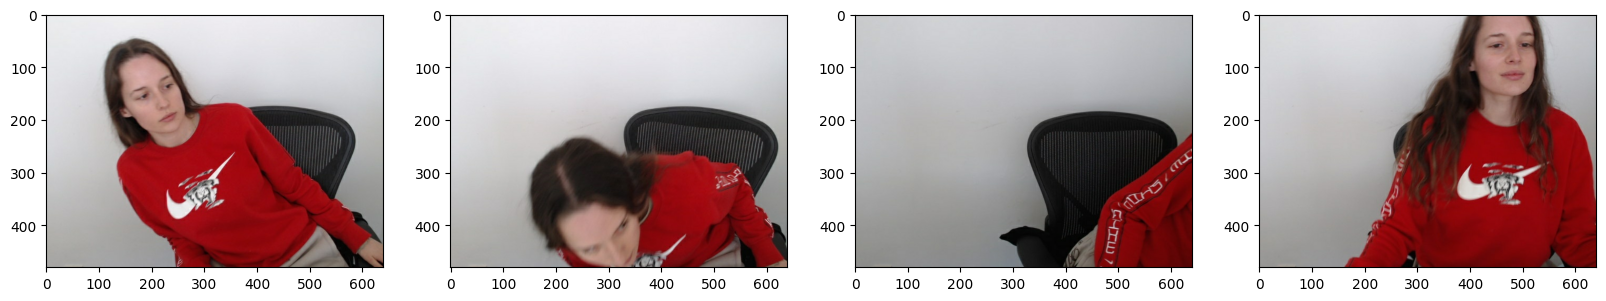

In [53]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [55]:
89*.7 # 62 to train

62.3

In [56]:
89*.15 # 14 and 13 to test and val

13.35

### 3.2 Move the Matching Labels

In [57]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [58]:
import albumentations as alb

In [59]:
#differents transofrmations : crop, brightness,rgb .... We will do 6 different transformations
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), #de base on est sur 480*640*3, et on crop 450*450
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels'])) #specify our banding box paramters (pascal_voc qui es t [x_min, y_min, x_max, y_max], albumentations, yolo, coco)

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [108]:
img = cv2.imread(os.path.join('data','train', 'images','8c17813f-dbd0-11ee-9fea-080027239d00.jpg'))

In [109]:
#img

In [110]:
with open(os.path.join('data', 'train', 'labels', '8c17813f-dbd0-11ee-9fea-080027239d00.json'), 'r') as f:
    label = json.load(f)

In [111]:
#label

In [112]:
label['shapes'][0]['points']

[[337.5757575757575, 1.5151515151515496],
 [471.5151515151515, 163.93939393939397]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [113]:
coords = [0,0,0,0] #we store coordonates in this array
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [114]:
coords #we transformed the coordonates du dessus in a vector : [x1,y1,x2,y2], et là on a les coordonnées en pascal

[337.5757575757575, 1.5151515151515496, 471.5151515151515, 163.93939393939397]

In [115]:
coords = list(np.divide(coords, [640,480,640,480])) #on divise par width height of image pr normaliser

In [116]:
coords #albumentation format

[0.5274621212121211,
 0.003156565656565728,
 0.7367424242424242,
 0.3415404040404041]

### 4.4 Apply Augmentations and View Results

In [117]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [118]:
augmented['image'].shape #ditcionnaire ac infos données au dessus

(450, 450, 3)

In [119]:
augmented['bboxes'][0][2:]

(0.40094276094276105, 1.0)

In [120]:
augmented['bboxes']

[(0.10329966329966334, 0.6556902356902357, 0.40094276094276105, 1.0)]

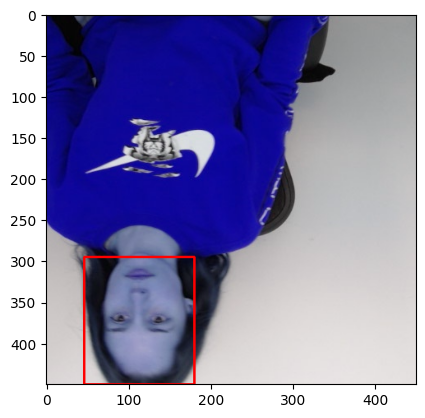

In [121]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),#top coordonates
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), #bottom coordonates
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [123]:
#we will apply augmentation in all our data

for partition in ['train','test','val']: #loop threw our 3 folders
    for image in os.listdir(os.path.join('data', partition, 'images')):#grap every image in these folders
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json') #if an annotation or not exists for this image (non positive images) if no anntofation we will add les values ds coords juste au dessus
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]#all of these is when annotations exist
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

##then we are creating 60 images per base image
        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])#we doing our augmentation
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 #and assign a class of 0 if no annotation neg casis


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [17]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False) #Our training images are going to be inside of a variable called train_images
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [18]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [19]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [20]:
train_images.as_numpy_iterator().next()

array([[[0.827451  , 0.84313726, 0.85490197],
        [0.8300858 , 0.8457721 , 0.8575368 ],
        [0.8352941 , 0.8509804 , 0.8627451 ],
        ...,
        [0.7973652 , 0.80128676, 0.8091299 ],
        [0.79607844, 0.8       , 0.81041664],
        [0.795527  , 0.79944855, 0.8151348 ]],

       [[0.83137256, 0.84705883, 0.85882354],
        [0.827451  , 0.84313726, 0.85490197],
        [0.83094364, 0.8466299 , 0.8583946 ],
        ...,
        [0.79656863, 0.8004902 , 0.80833334],
        [0.79656863, 0.8004902 , 0.81531864],
        [0.79969364, 0.8036152 , 0.8193015 ]],

       [[0.82598037, 0.8455882 , 0.8573529 ],
        [0.82052696, 0.8401348 , 0.8518995 ],
        [0.82751226, 0.8471201 , 0.8588848 ],
        ...,
        [0.7921569 , 0.79607844, 0.8117647 ],
        [0.79607844, 0.8       , 0.8156863 ],
        [0.7978554 , 0.80177695, 0.8213848 ]],

       ...,

       [[0.54901963, 0.5568628 , 0.54509807],
        [0.54901963, 0.54901963, 0.5421569 ],
        [0.5485294 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [21]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [22]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [23]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [24]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [25]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3857, 0.2458, 0.81  , 0.7466], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [26]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3720, 3720, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [27]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8) #each patch will represent 8 images and 8 labels
train = train.prefetch(4)

In [28]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [29]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [30]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0]], dtype=uint8),
 array([[0.6616 , 0.7    , 0.928  , 0.999  ],
        [0.3818 , 0.3252 , 0.81   , 0.751  ],
        [0.9287 , 0.3936 , 1.     , 0.7905 ],
        [0.3577 , 0.     , 0.883  , 0.3882 ],
        [0.1193 , 0.03757, 0.3564 , 0.362  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.3    , 0.623  , 0.8267 , 1.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

### 7.3 View Images and Annotations

In [31]:
data_samples = train.as_numpy_iterator()

In [32]:
type(data_samples)

tensorflow.python.data.ops.dataset_ops.NumpyIterator

In [33]:
res = data_samples.next()

In [42]:
res[1][1][0]

array([0.1696, 0.1611, 0.4604, 0.509 ], dtype=float16)

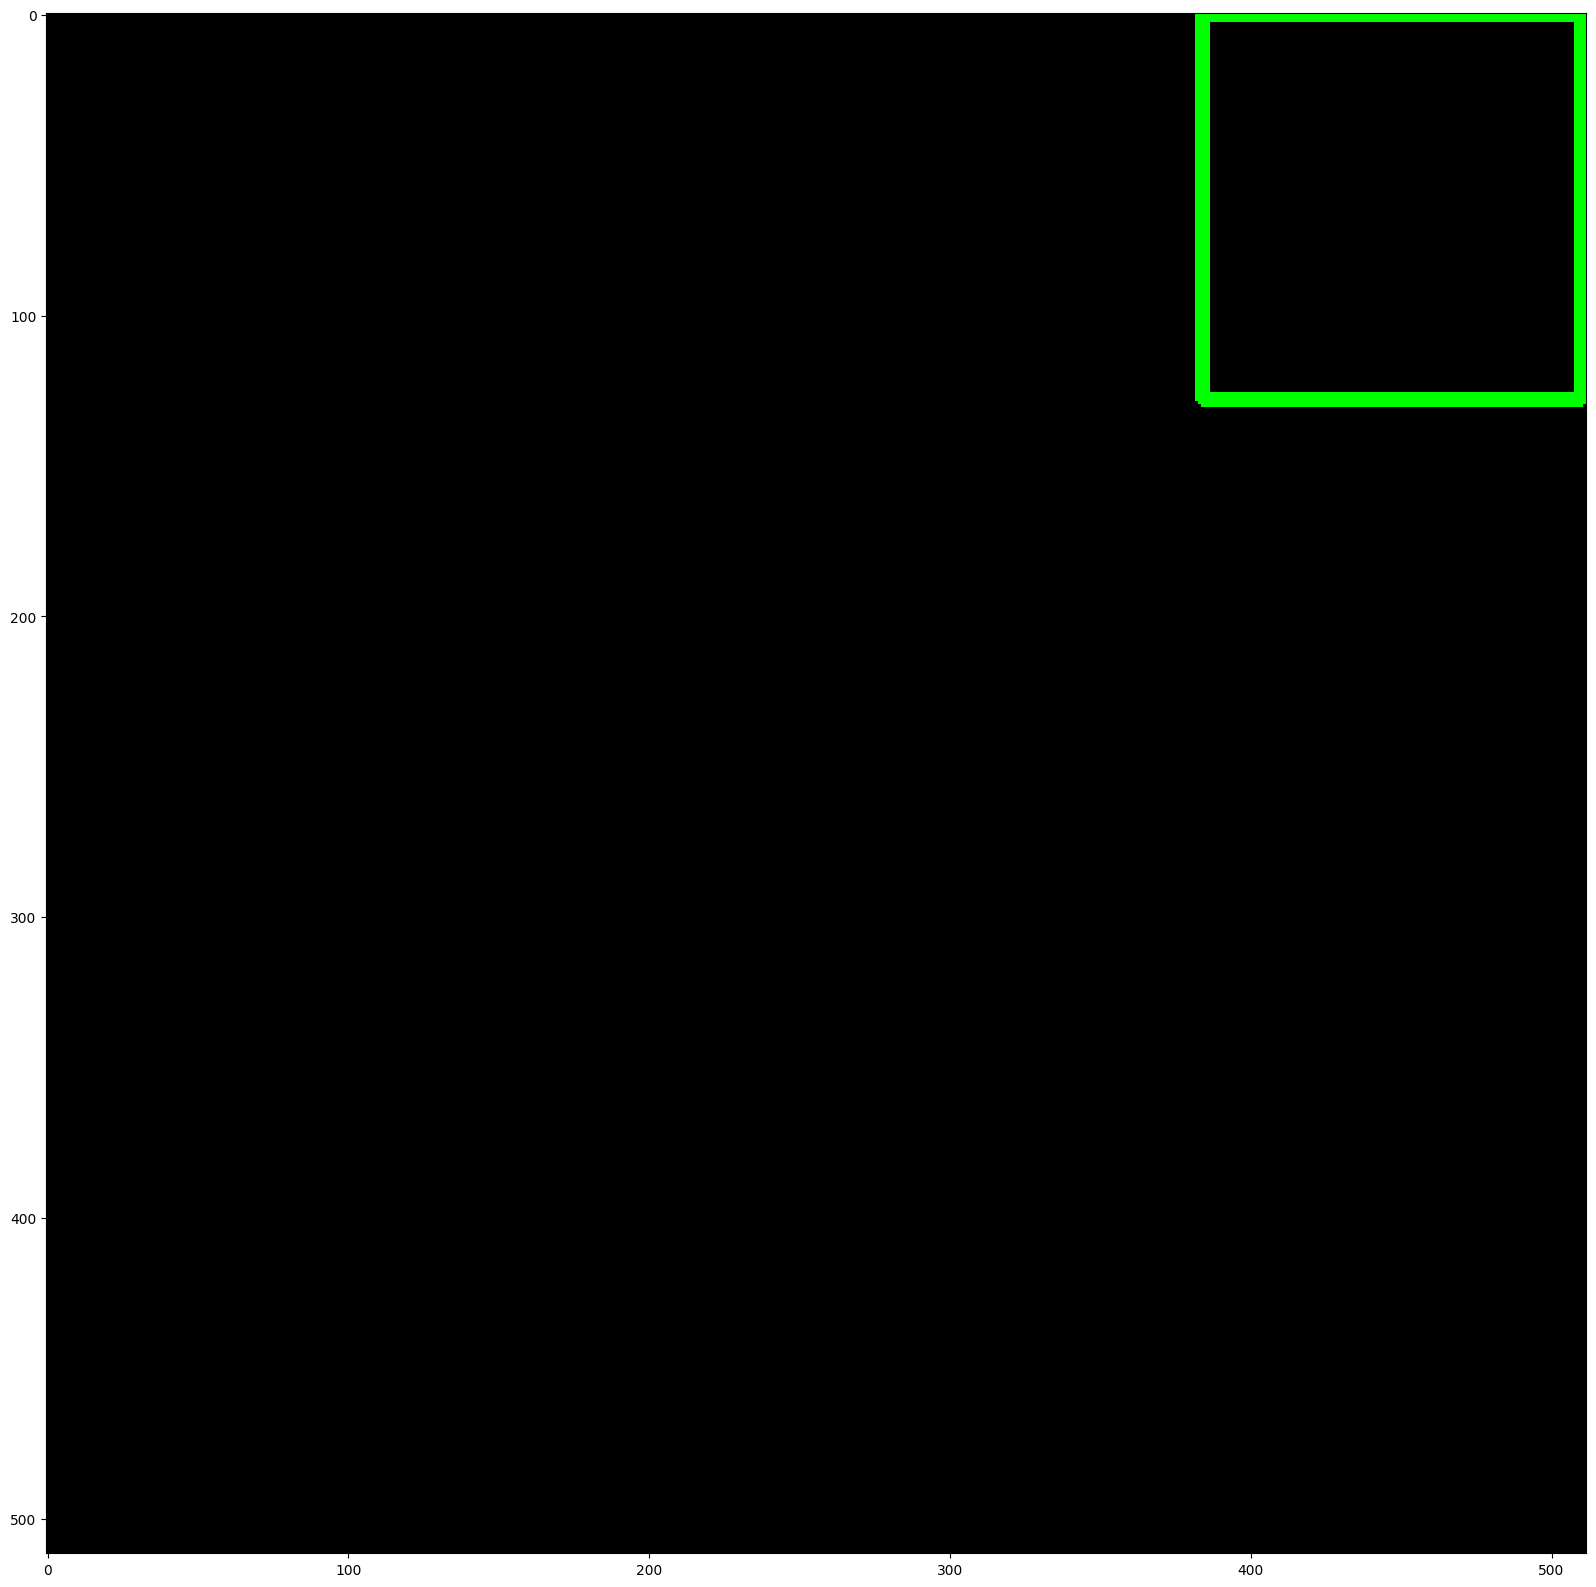

In [37]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

fig, ax = plt.subplots(ncols=1, figsize=(20,20))
img = np.zeros((512,512,3), np.uint8)
cv2.rectangle(img,(384,0),(510,128),(0,255,0),3)
ax.imshow(img)

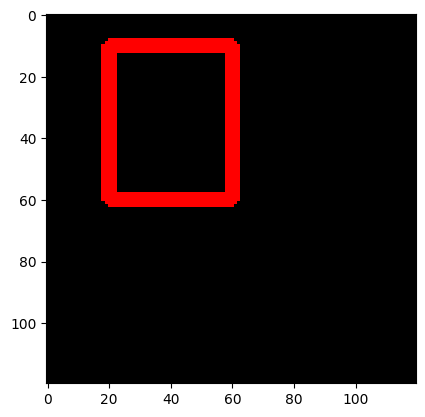

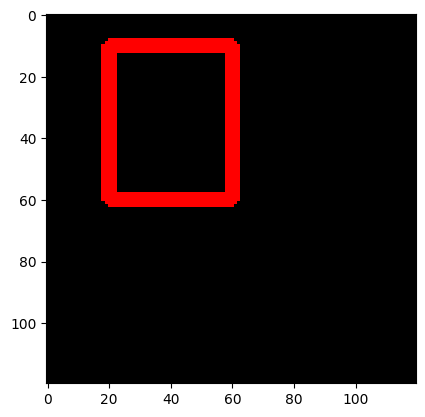

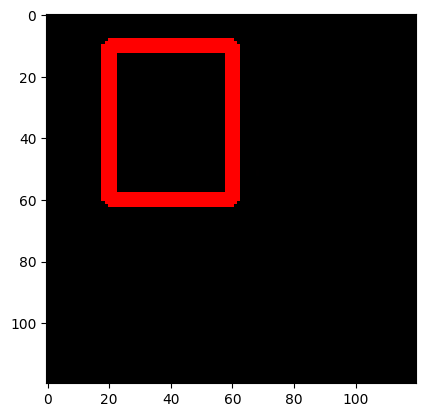

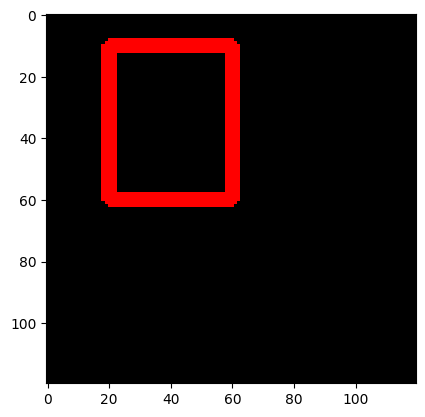

In [111]:
for idx in range(4):
    plt.figure()
    sample_image = res[0][idx].astype(np.uint8)
    #copy_image = sample_image.copy()
    #print(copy_image.shape)
    sample_coords = res[1][1][idx]
    #copy_image = copy_image.astype(np.int32)
    cv2.rectangle(sample_image, (20,10), (60,60), (255,0,0), 4)
    #print()
    #cv2.rectangle(sample_image, 
                  #tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  #tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                  #      (255,0,0), 2)
    plt.imshow(sample_image)

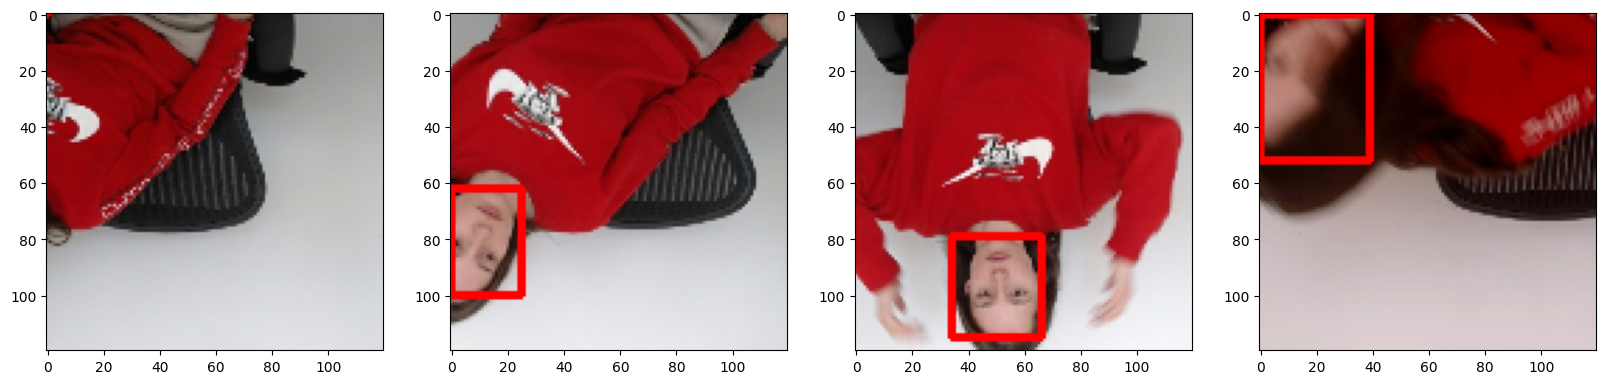

In [115]:
from PIL import Image
import numpy as np

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = (res[0][idx]*255).astype(np.uint8)
    #copy_image = sample_image.copy()
    #print(copy_image.shape)
    sample_coords = res[1][1][idx]
    #copy_image = copy_image.astype(np.int32)
    #cv2.rectangle(sample_image, (20,10), (60,60), (255,0,0), 4)
    #print()
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [57]:
vgg = VGG16(include_top=False)

In [58]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [59]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [60]:
facetracker = build_model()

In [61]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_5[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [62]:
X, y = train.as_numpy_iterator().next()

In [63]:
X.shape

(8, 120, 120, 3)

In [64]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 702ms/step


In [65]:
classes, coords

(array([[0.50894356],
        [0.5044177 ],
        [0.3799221 ],
        [0.44624624],
        [0.38966894],
        [0.56216323],
        [0.51342213],
        [0.51840466]], dtype=float32),
 array([[0.7328444 , 0.5876814 , 0.4950552 , 0.23752058],
        [0.58820564, 0.56499374, 0.59087324, 0.23924707],
        [0.67524844, 0.62174684, 0.5604277 , 0.26869193],
        [0.57116663, 0.5824201 , 0.55136156, 0.24079894],
        [0.64854026, 0.620723  , 0.4919066 , 0.23283261],
        [0.6261019 , 0.6178598 , 0.5320361 , 0.26243278],
        [0.665394  , 0.6467214 , 0.48405448, 0.28996435],
        [0.7260174 , 0.64266825, 0.50375944, 0.25137663]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [66]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [67]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [68]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [69]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [76]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.250153>

In [77]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7672459>

In [78]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.250153>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [79]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [80]:
model = FaceTracker(facetracker)

In [81]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [82]:
logdir='logs'

In [83]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [84]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
465/465 [==============================] - 962s 2s/step - total_loss: 0.4197 - class_loss: 0.1215 - regress_loss: 0.3589 - val_total_loss: 0.6380 - val_class_loss: 0.5361 - val_regress_loss: 0.3699
Epoch 2/10
465/465 [==============================] - 954s 2s/step - total_loss: 0.1083 - class_loss: 0.0311 - regress_loss: 0.0927 - val_total_loss: 0.0041 - val_class_loss: 0.0018 - val_regress_loss: 0.0031
Epoch 3/10
465/465 [==============================] - 984s 2s/step - total_loss: 0.0552 - class_loss: 0.0169 - regress_loss: 0.0468 - val_total_loss: 0.0087 - val_class_loss: 6.4251e-04 - val_regress_loss: 0.0083
Epoch 4/10
465/465 [==============================] - 973s 2s/step - total_loss: 0.0537 - class_loss: 0.0165 - regress_loss: 0.0455 - val_total_loss: 0.2753 - val_class_loss: 0.1926 - val_regress_loss: 0.1790
Epoch 5/10
465/465 [==============================] - 948s 2s/step - total_loss: 0.0648 - class_loss: 0.0195 - regress_loss: 0.0550 - val_total_loss: 0.0298 - v

### 10.3 Plot Performance

In [85]:
hist.history

{'total_loss': [0.07102654874324799,
  0.04699615761637688,
  0.013293961994349957,
  0.013187013566493988,
  0.018462862819433212,
  0.013759849593043327,
  0.008730503730475903,
  0.008156801573932171,
  0.011241632513701916,
  0.012511173263192177],
 'class_loss': [0.0023902603425085545,
  0.000469426391646266,
  0.00530416751280427,
  0.00034645787673071027,
  0.0005290054250508547,
  0.0002877528022509068,
  3.901985473930836e-05,
  0.00025619607185944915,
  5.7863340771291405e-05,
  0.00011215172708034515],
 'regress_loss': [0.06983141601085663,
  0.046761445701122284,
  0.010641878470778465,
  0.013013784773647785,
  0.01819835975766182,
  0.01361597329378128,
  0.008710993453860283,
  0.00802870374172926,
  0.011212700977921486,
  0.012455097399652004],
 'val_total_loss': [0.63797926902771,
  0.004062680061906576,
  0.008660460822284222,
  0.2752659320831299,
  0.02984810620546341,
  0.2485342025756836,
  0.006015653256326914,
  0.06651259958744049,
  0.009396009147167206,
  0.

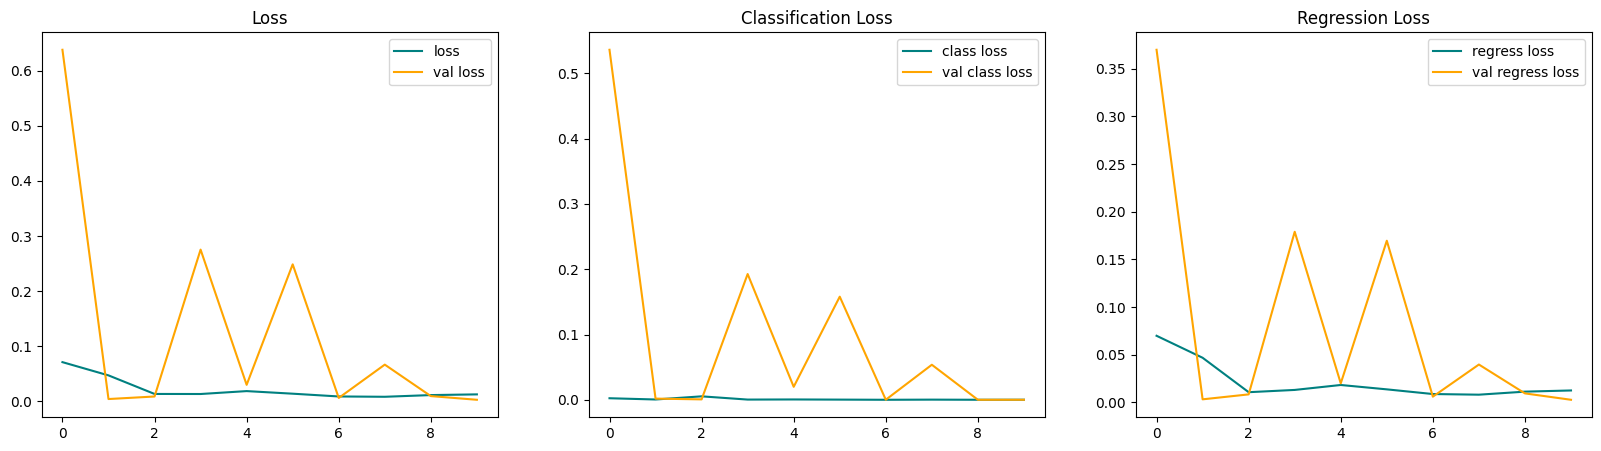

In [86]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [87]:
test_data = test.as_numpy_iterator()

In [88]:
test_sample = test_data.next()

In [117]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 819ms/step


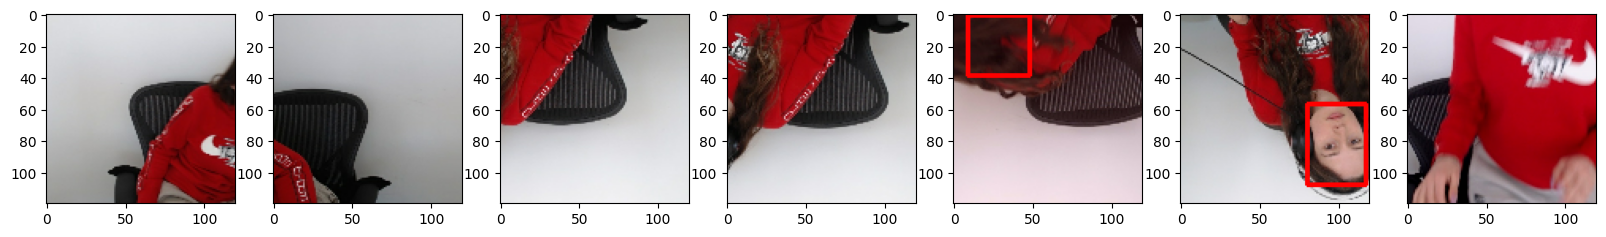

In [121]:
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx in range(7): 
    sample_image = (test_sample[0][idx]*255).astype(np.uint8)
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [107]:
from tensorflow.keras.models import load_model

In [126]:
facetracker.save('facetracker.h5')

In [127]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [130]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 110ms/step
